In [1]:
root_path = "/tf/home/sergio/Tesis"

In [2]:
import os
os.getcwd()

'/tf/home/sergio/Tesis/TinyYOLOv3-Pedestrian-Detection/Dataset Preprocessing'

In [3]:
import sys
sys.path.append(root_path+"/TinyYOLOv3-Pedestrian-Detection")
from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

from skimage.io import imread,imshow
from skimage.transform import resize
import time
import os

from pycocotools.coco import COCO

In [4]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    #print(box_arr1)
    #print(box_arr2)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    #print(xA)
    yA = tf.maximum(y11, tf.transpose(y21))
    #print(yA)
    xB = tf.minimum(x12, tf.transpose(x22))
    #print(xB)
    yB = tf.minimum(y12, tf.transpose(y22))
    #print(yB)
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    #print("interseccion",interArea)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    #print("area gt",boxAArea)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    #print("area pre",boxBArea)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    #print(iou)
    return tf.cast(iou>=0.5,dtype=tf.int32),iou

import numpy as np
def yxyx_to_yxwh(bbox):
    x_min,y_min,x_max,y_max=np.split(bbox,4,axis=0)
    
    width = x_max-x_min
    height = y_max-y_min
    x_center = x_min + (width/2)
    y_center = y_min + (height/2)
    
    out = np.concatenate((x_center,y_center,width,height))
    
    return out

def errors(bbox_pred,bbox_gt):
    
    bbox_pred = yxyx_to_yxwh(bbox_pred)
    bbox_gt = yxyx_to_yxwh(bbox_gt)
    
    xy_error = np.square(bbox_pred[0]-bbox_gt[0]) + np.square(bbox_pred[1]-bbox_gt[1]) 
    wh_error = np.square(bbox_pred[3]-bbox_gt[3]) + np.square(bbox_pred[2]-bbox_gt[2])
    
    return (xy_error,wh_error)

In [5]:
import cv2
BOX_COLOR = (0, 0, 255)
#BOX_COLOR = (255,0,0)
def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def generate_image(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        #print(idx)
        img = visualize_bbox(img, bbox)
    #plt.imshow(img)
    return img
    
def new_frame(image,bboxes,color=BOX_COLOR):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        #print(idx)
        img = visualize_bbox(img, bbox,color=color)
    return img

In [6]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end

    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

## Cargamos las anotaciones de los estudios de caso

In [7]:
import json

os.chdir(root_path+"/imagenes_estudio_caso")
with open('5_coco_imglab.json') as json_file:
    data = json.load(json_file)

In [8]:
images_metadata_df = pd.DataFrame(data["images"])

In [9]:
images_metadata_df

,file_name,height,width,id
0,pedestrians_example4.jpg,720,1280,1
1,pedestrians_example5.jpg,432,768,2
2,pedestrians_example12.jpg,381,678,3
3,pedestrians_example.jpg,960,720,4
4,pedestrians_example7.jpg,609,1080,5


In [10]:
images_annotations_df = pd.DataFrame(data["annotations"]).drop(["segmentation","area","iscrowd","category_id","id","ignore"],axis=1)
images_annotations_df[['xmin','ymin','xmax',"ymax"]] = pd.DataFrame(images_annotations_df.bbox.tolist(), index= images_annotations_df.index)
images_annotations_df = images_annotations_df.drop(["bbox"],axis=1)

center_x,center_y,width,height =np.split(images_annotations_df.iloc[:,1:].values,4,axis=1)

top_left_x = center_x# - (width / 2)
top_left_y = center_y# - (height / 2)
bottom_right_x = center_x + (width)
bottom_right_y = center_y + (height)

voc_anotations = np.concatenate([top_left_x,top_left_y,bottom_right_x,bottom_right_y],axis=1)
images_annotations_df[['xmin','ymin','xmax',"ymax"]]=voc_anotations

#images_annotations_df.image_id =images_annotations_df.image_id.replace({1:"pedestrians_example4.jpg",2:"pedestrians_example5.jpg",
#                                       3:"pedestrians_example12.jpg",4:"pedestrians_example.jpg",
#                                       5: "pedestrians_example7.jpg"})

total_objects = images_annotations_df.shape[0]

In [11]:
total_objects

60

In [12]:
images_annotations_df.head()

,image_id,xmin,ymin,xmax,ymax
0,1,66.0,175.0,240.0,589.0
1,1,214.0,157.0,525.0,716.0
2,1,504.0,280.0,741.0,708.0
3,1,821.0,191.0,1001.0,609.0
4,1,1074.0,193.0,1247.0,613.0


## Modelo original

In [13]:
anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
model_original = TinyYOLOv3(80,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model_original.build(batch_input_shape=(None,416,416,3))
model_original.load_weights_darknet(root_path+"/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights")

Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)


8858734

## Modelo mejorado

In [14]:
num_anchors = 3


if num_anchors == 3:
    anchors =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]
    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.4)
    model.build(batch_input_shape=(None,416,416,3))    
    '''3 anchors 50 epocas con pesos 5521, posiblemente mejor resultado, y con losses msle y mse del exponencial epochs_30 = 0.12125929824973192, epoch_50 = 0.1228'''
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_1e-5_msle_exp_mse_3anchors_NUEVO_TRAIN')

    #model.load_weights(root_path+'/last_weights/pesos_finetuning_2211_70_80_epoch_nadam_0dot00001_mse_exp_mse_3anchors_con_data_aug')

    
else: 
    anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]

    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
    model.build(batch_input_shape=(None,416,416,3))

    '''2 anchors co nadam y msle y exp msecon 1241 de lambdas'''
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_70_to_90_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights(root_path+'/weights_saved/pesos_1241_90_to_110_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights(root_path+'/weights_saved/pesos_1441_110_to_130_epoch_nadam_0dot000001_msle_exp_mse')
    model.load_weights(root_path+'/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')




Solo es una clase


In [15]:
def count_boxes(groud_truth_bboxes,predicted_boxes,scores):
    final_output=pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])
    
    for box,score in zip(predicted_boxes,scores):

        iou_resulted,iou = get_iou_matrix_tf(groud_truth_bboxes, box[tf.newaxis,:])
        
        if np.sum(iou_resulted) >= 1:
            tp = 1
            fp = 0
            which_gt = np.argmax(iou)
            iou_value = np.max(iou)
            #print(iou_value)
            coord_gt = groud_truth_bboxes[which_gt,:]
            
            xy_error,wh_error = errors(box,coord_gt)
            
            groud_truth_bboxes=np.delete(groud_truth_bboxes,which_gt,axis=0)
        #NO hay algún ground truth con el que tenga mas de 0.5 de IoU    
        elif np.sum(iou_resulted) == 0:
            fp = 1
            tp = 0
            
            
            #EL objeto predicho de plano no machea con ninǵún ground truth
            if iou.shape[0]>0  and np.sum(iou)==0:
                iou_value=0
                xy_error=-1
                wh_error=-1    
            #EL objeto predicho hizo match con algún ground truth pero no lo suficiente paara ser un TP    
            elif iou.shape[0]>0  and np.sum(iou)>0:
                
                iou_value = np.max(iou)
                which_gt = np.argmax(iou)
                coord_gt = groud_truth_bboxes[which_gt,:]
                xy_error,wh_error = errors(box,coord_gt)                
                
            # La red detecto un objecto donde ya no hay groudn truth 
            elif iou.shape[0]==0:
                
                iou_value=0
                xy_error=-2
                wh_error=-2     

        predicted_dict = {"file_name":[image],"xmin":[box[0]],"ymin":[box[1]],"xmax":[box[2]],"ymax":[box[3]],"score":[score],
                          "xy_error":[xy_error],"wh_error":[wh_error],"iou":[iou_value],"TP":[tp],"FP":[fp]}
        

        aux = pd.DataFrame(predicted_dict)
        final_output=pd.concat((final_output,aux),ignore_index=True)            
        
    return final_output

def ap_processing(detections_df):
    detections_df = detections_df.sort_values(by="score",ascending=False)
    cum_tp = np.cumsum(detections_df["TP"].values)
    cum_fp = np.cumsum(detections_df["FP"].values)
    detections_df.insert(detections_df.shape[1],"cum TP",cum_tp)
    detections_df.insert(detections_df.shape[1],"cum FP",cum_fp)
    detections_df["Precision"]= (detections_df.loc[:,"cum TP"]/(detections_df.loc[:,"cum TP"] + detections_df.loc[:,"cum FP"])).astype(np.float32)
    detections_df["Recall"]= (detections_df.loc[:,"cum TP"]/total_objects).astype(np.float32)
    detections_df["FP"]=detections_df["FP"].astype(np.int32)
    detections_df["TP"]=detections_df["TP"].astype(np.int32)
    detections_df["xy_error"] = detections_df["xy_error"].astype(np.float32)
    detections_df["wh_error"] = detections_df["wh_error"].astype(np.float32)

    return detections_df


In [16]:
os.chdir(root_path+"/imagenes_estudio_caso")

detections_df = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])
detections_df_original = pd.DataFrame(columns=["file_name","xmin","ymin","xmax","ymax","score","xy_error","wh_error","TP","FP"])


results_eval = []
obj_thresh = 0.5

nms = True
original = True

inicio = time.time()
for image in range(1,6):
    print(image)
    annotations_images_df = images_annotations_df[images_annotations_df.image_id==image]

    image_name = images_metadata_df[images_metadata_df.id==image]["file_name"].values[0]
    image_height = images_metadata_df[images_metadata_df.id==image]["height"].values[0]
    image_width = images_metadata_df[images_metadata_df.id==image]["width"].values[0]
    
    groud_truth_bboxes = annotations_images_df[annotations_images_df.image_id==image].values[:,1:].astype(np.float32)
    groud_truth_bboxes[:,[0,2]] = np.divide(groud_truth_bboxes[:,[0,2]],image_width)
    groud_truth_bboxes[:,[1,3]] = np.divide(groud_truth_bboxes[:,[1,3]],image_height)
    
    img_raw = tf.image.decode_image(open(image_name, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    

    boxes,scores = model(img);
    predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
    scores = scores.numpy()
    detections_df = pd.concat((detections_df,count_boxes(groud_truth_bboxes,predicted_boxes,scores)),ignore_index=True)  
    #print(detections_df)

    outputs = model_original(img);
    real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
    person_index = np.where(real_outputs ==0)
    predicted_boxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
    scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]
    detections_df_original = pd.concat((detections_df_original,count_boxes(groud_truth_bboxes,predicted_boxes,scores)),ignore_index=True)  

        
detections_df = ap_processing(detections_df)
detections_df_original = ap_processing(detections_df_original)
        #print(aux)        
        
        #print(groud_truth_bboxes)
        #print(iou)


fin = time.time()
print(fin-inicio)

1
Solo es una clase
2
3
4
5
1.9975578784942627


In [17]:
detections_df.tail()

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
8,2,0.436973,0.285739,0.489783,0.568712,0.578224,0.002007,0.002674,1,0,0.676697,19,12,0.612903,0.316667
19,3,0.200417,0.163846,0.268695,0.614830,0.543079,0.003809,0.000178,1,0,0.653905,20,12,0.625000,0.333333
3,1,0.008129,0.240253,0.157355,0.843607,0.523555,0.001483,0.000980,1,0,0.566553,21,12,0.636364,0.350000
25,4,0.681379,0.362109,0.864042,0.720462,0.508069,0.000914,0.000141,1,0,0.813332,22,12,0.647059,0.366667
34,5,0.588578,0.227999,0.649030,0.554286,0.500477,0.001288,0.001542,0,1,0.365164,22,13,0.628571,0.366667


In [18]:
detections_df_original.tail()

,file_name,xmin,ymin,xmax,ymax,score,xy_error,wh_error,TP,FP,iou,cum TP,cum FP,Precision,Recall
9,3,0.221628,0.338154,0.264642,0.559669,0.659611,0.000110,0.051903,0,1,0.264508,12,10,0.545455,0.200000
20,4,0.471544,0.420935,0.624747,0.707714,0.634540,0.000301,0.006134,1,0,0.681121,13,10,0.565217,0.216667
21,4,0.013548,0.534794,0.047743,0.656344,0.630320,0.000050,0.020577,0,1,0.211713,13,11,0.541667,0.216667
5,2,0.543833,0.417978,0.581550,0.553447,0.621199,0.000346,0.022415,0,1,0.237023,13,12,0.520000,0.216667
10,3,0.270868,0.340883,0.312468,0.557597,0.608855,0.000198,0.031197,0,1,0.326446,13,13,0.500000,0.216667


In [19]:
def get_resulted_image(image,images_annotations_df,detections_df):
    
    annotations_images_df = images_annotations_df[images_annotations_df.image_id==image]
    #print(len(annotations_images_df))
    #print(len(detections_df))
    image_name = images_metadata_df[images_metadata_df.id==image]["file_name"].values[0]
    image_height = images_metadata_df[images_metadata_df.id==image]["height"].values[0]
    image_width = images_metadata_df[images_metadata_df.id==image]["width"].values[0]
    
    groud_truth_bboxes = annotations_images_df[annotations_images_df.image_id==image].values[:,1:].astype(np.float32)
    print(len(groud_truth_bboxes))
    
    detection_image = detections_df[detections_df.file_name==image].iloc[:,:10]

    print(len(detection_image))
    
    cum_tp = np.cumsum(detection_image["TP"].values)
    cum_fp = np.cumsum(detection_image["FP"].values)
    detection_image.insert(detection_image.shape[1],"cum TP",cum_tp)
    detection_image.insert(detection_image.shape[1],"cum FP",cum_fp)
    
    detection_image["Precision"]= (detection_image.loc[:,"cum TP"]/(detection_image.loc[:,"cum TP"] + detection_image.loc[:,"cum FP"])).astype(np.float32)
    detection_image["Recall"]= (detection_image.loc[:,"cum TP"]/len(annotations_images_df)).astype(np.float32)
    
    precision =detection_image["Precision"].iloc[-1]
    recall = detection_image["Recall"].iloc[-1]
    f1_score =2*precision*recall/(precision+recall)
    
    
    ap = compute_ap(detection_image["Recall"].values, detection_image["Precision"].values)
    
    predictions = detections_df[detections_df.file_name==image].iloc[:,1:5].values
    #display(detection_image)
    
    predictions[:,[0,2]] = predictions[:,[0,2]]*image_width
    predictions[:,[1,3]] = predictions[:,[1,3]]*image_height

    img_raw = tf.image.decode_image(open(image_name, 'rb').read(), channels=3)
    annotated_image_first = new_frame(img_raw.numpy(),np.int32(groud_truth_bboxes),color=(0,255,0))
    annotated_image_final = new_frame(annotated_image_first,np.int32(predictions),color=(255,0,0))
    
    results = {"Precision":[precision],"Recall":[recall],"f1 Score":[f1_score],"AP":[ap]}
    
    return annotated_image_final,annotated_image_first,results

In [23]:
image=1

annotated_image,ann_image_first,results = get_resulted_image(image,images_annotations_df,detections_df)
annotated_image_original,ann_image_first,results_original= get_resulted_image(image,images_annotations_df,detections_df_original)
results =pd.concat((pd.DataFrame(results),pd.DataFrame(results_original))).T
results.columns = ['Refined', 'Original']

9
4
9
3


In [24]:
display(results)

,Refined,Original
Precision,0.750000,1.000000
Recall,0.333333,0.333333
f1 Score,0.461538,0.500000
AP,0.250000,0.333333


In [22]:
#plt.figure(figsize = (12,18))
plt.figure(figsize = (20,12))

image_name = images_metadata_df[images_metadata_df.id==image]["file_name"].values[0]
img_raw = tf.image.decode_image(open(image_name, 'rb').read(), channels=3)

gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.1) 


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]


plt.subplot(gs1[0])
plt.title("a)",fontsize=16)
plt.imshow(img_raw)
plt.axis("off")

plt.subplot(gs1[2])
plt.title("c)",fontsize=16)
plt.imshow(annotated_image)
plt.axis("off")

plt.subplot(gs1[3])
plt.title("d)",fontsize=16)
plt.imshow(annotated_image_original)
plt.axis("off")

plt.subplot(gs1[1])
plt.title("b)",fontsize=16)
plt.imshow(ann_image_first)
plt.axis("off")
#plt.savefig("comparativa_estudio_caso_"+str(image)+".png",pdi=100,format="png")

print("Total objects:")

NameError: name 'gridspec' is not defined

<Figure size 1440x864 with 0 Axes>

## Modelo original

In [5]:
anchors =[[10/416,14/416],[23/416,27/416],[37/416,58/416],[81/416,82/416],[135/416,169/416],[344/416,319/416]]
model_original = TinyYOLOv3(80,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model_original.build(batch_input_shape=(None,416,416,3))
model_original.load_weights_darknet(root_path+"/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights")

Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)


8858734

## Modelo mejorado

In [6]:
num_anchors = 3


if num_anchors == 3:
    anchors =[[0.02078,0.049],[0.0426,0.128],[0.08523,0.19356],[0.1506,0.4163],[0.27835,0.58651],[0.5632,0.78614]]
    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.4)
    model.build(batch_input_shape=(None,416,416,3))    
    '''3 anchors 50 epocas con pesos 5521, posiblemente mejor resultado, y con losses msle y mse del exponencial epochs_30 = 0.12125929824973192, epoch_50 = 0.1228'''
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_10_30_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_30_50_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights(root_path+'/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_0dot00001_msle_exp_mse_3anchors')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_finetuning_5521_50_70_epoch_nadam_1e-5_msle_exp_mse_3anchors_NUEVO_TRAIN')
else: 
    anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]

    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
    model.build(batch_input_shape=(None,416,416,3))

    '''2 anchors co nadam y msle y exp msecon 1241 de lambdas'''
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_70_to_90_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights(root_path+'/weights_saved/pesos_1241_90_to_110_epoch_nadam_0dot0001_msle_exp_mse')
    #model.load_weights(root_path+'/weights_saved/pesos_1441_110_to_130_epoch_nadam_0dot000001_msle_exp_mse')
    model.load_weights(root_path+'/weights_saved/pesos_1441_130_to_140_epoch_nadam_0dot000001_msle_exp_mse')




Solo es una clase


### Cargamos la imagen

In [48]:
os.chdir(root_path+"/TinyYOLOv3-Pedestrian-Detection/Dataset Preprocessing")

num_image = ""

image = "pedestrians_example7.jpg"
#image = "pedestrians_example12"+str(num_image)+".jpg"
img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
_,height,width,_ =img.shape
img = tf.image.resize(img, (416, 416))/255

## Predicción usando el modelo mejorado

In [49]:
inicio = time.time()
boxes,scores = model(img);
fin = time.time()
print("Tiempo inferencia usando el modelo original",fin-inicio)

predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
scores = scores.numpy()

predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]*width
predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]*height

img_bboxes = new_frame(img_raw.numpy(),np.int32(predicted_boxes),color=(255,0,0))

Tiempo inferencia usando el modelo original 0.014068126678466797


## Predicción usando el modelo original

In [50]:
inicio = time.time()
outputs = model_original(img);
fin = time.time()
print("Tiempo inferencia usando el modelo original",fin-inicio)
real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
person_index = np.where(real_outputs ==0)
predicted_boxes_original = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]

predicted_boxes_original[:,[0,2]] = predicted_boxes_original[:,[0,2]]*width
predicted_boxes_original[:,[1,3]] = predicted_boxes_original[:,[1,3]]*height

img_bboxes_original = new_frame(img_raw.numpy(),np.int32(predicted_boxes_original),color=(0,0,255))

Tiempo inferencia usando el modelo original 0.03137826919555664


In [51]:
outputs

CombinedNonMaxSuppression(nmsed_boxes=<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.05408962, 0.32764888, 0.21550314, 0.93161476],
        [0.18423654, 0.28637826, 0.3308671 , 0.9194473 ],
        [0.7180395 , 0.3841392 , 0.7676176 , 0.5863877 ],
        [0.5366036 , 0.37333888, 0.58322865, 0.5029119 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.    

<Figure size 1080x1080 with 0 Axes>

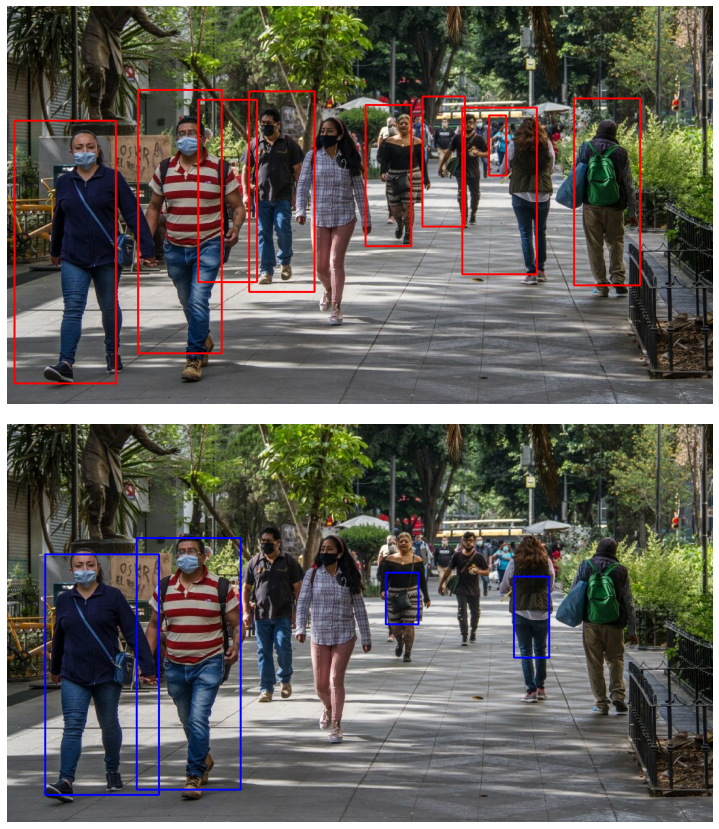

In [52]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (15,15))

if width>height:
    
    gs1 = gridspec.GridSpec(2, 1)
else:
    gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.025, hspace=0.05) 


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.figure()

plt.subplot(gs1[0])
plt.imshow(img_bboxes)
plt.axis("off")

plt.subplot(gs1[1])
plt.imshow(img_bboxes_original)
plt.axis("off")



os.chdir(root_path+"/TinyYOLOv3-Pedestrian-Detection/Dataset Preprocessing/images_results")

plt.savefig("pedestrian_example_result"+str(num_image),format="png")

## Generación de video DEMO

In [255]:
print(os.getcwd())

/tf/home/sergio


In [279]:
os.chdir('/tf/home/sergio')

#cap = cv2.VideoCapture('Atropellan a 7 peatones al día en la CDMX.mp4')
cap = cv2.VideoCapture('Madeo_peatones.mp4')

#result = cv2.VideoWriter('output.mp4',  
#                         cv2.VideoWriter_fourcc(*'MP4V'), 
#                         30, (1920, 1080)) 

#result = cv2.VideoWriter('madero_output_comparative.mp4',  
#                         cv2.VideoWriter_fourcc(*'MP4V'), 
#                         30, (1280, 1440)) 

result = cv2.VideoWriter('madero_output_comparative_same.mp4',  
                         cv2.VideoWriter_fourcc(*'MP4V'), 
                         30, (1280, 720)) 

#cap = cv2.VideoCapture('Atropellan a 7 peatones al día en la CDMX.mp4')

In [280]:
num_frames = 0

while(True): 
    
    if num_frames<=10000:
        #Leemos el frame original
        ret, frame_original = cap.read() 
        #print(frame_original.dtype)
        #print(frame_original[0,0,:])
        if num_frames>=2700:
            if ret == True:
                #OpenCV lee el frame en formato BGR , lo pasamos a RGB
                frame = cv2.cvtColor(frame_original, cv2.COLOR_BGR2RGB)
                #print(frame.shape)
                #print(frame.dtype)
                #print(frame[0,0,:])
                #Lo normalizamos y lo pasamos a redimensionamos a (416,416,3)
                img = tf.expand_dims(frame, 0)
                _,height,width,_ =img.shape
                img = tf.image.resize(img, (416, 416))/255

                ###########################################################
                boxes,scores = model(img);
                predicted_boxes = np.clip(boxes.numpy()[0,:,:],0,1)#[indices.numpy(),:]
                scores = scores.numpy()

                predicted_boxes[:,[0,2]] = predicted_boxes[:,[0,2]]*width
                predicted_boxes[:,[1,3]] = predicted_boxes[:,[1,3]]*height

                processed_image = new_frame(frame_original,np.int32(predicted_boxes),color=(0,0,255))
                
                #cv2.putText(processed_image, "Ours",(50,50),fontFace = cv2.FONT_ITALIC,fontScale = 1,color = (255, 255, 255),thickness = 2 )
                ###########################################################


                ###########################################################
                outputs = model_original(img);

                real_outputs = outputs[2].numpy()[0,0:outputs[3][0].numpy()]
                person_index = np.where(real_outputs ==0)
                #print(person_index)
                #person_outputs 
                predicted_boxes_original = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:][person_index,:][0,:,:]
                scores = outputs[1].numpy()[0,0:outputs[3][0].numpy()][person_index]

                predicted_boxes_original[:,[0,2]] = predicted_boxes_original[:,[0,2]]*width
                predicted_boxes_original[:,[1,3]] = predicted_boxes_original[:,[1,3]]*height

                processed_image_original = new_frame(processed_image,np.int32(predicted_boxes_original),color=(255,0,0))
                
                #cv2.putText(processed_image_original, "Original",(50,50),fontFace = cv2.FONT_ITALIC,fontScale = 1,color = (255, 255, 255),thickness = 2 )
                ###########################################################

                #final_image = np.concatenate((processed_image,processed_image_original),axis=0)
                
                #processed_image_original = new_frame(frame_original,np.int32(predicted_boxes))
                #print(processed_image[0,0,:])
                #outputdata =((processed_image)*255).astype(np.uint8)
                #outputdata =((1-processed_image)*255).astype(np.uint8)
                #outputdata = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)

                #print(outputdata.shape)
                #print(outputdata.dtype)
                #print(outputdata[0,0,:])
                #result.write(final_image)
                result.write(processed_image_original)
                    
                num_frames+=1
            else:
                break
        else:
            num_frames+=1
    else:
        break
    
cap.release() 
result.release() 

In [218]:
final_image.shape

(1440, 1280, 3)

In [154]:
width

1280

In [51]:
cap.release() 
result.release() 

In [45]:
num_frames

3851

In [44]:
cap.release() 
result.release() 

In [38]:
processed_image.shape

(1080, 1920, 3)

In [39]:
os.listdir()

['detections_df_best_result_2_anchors',
 'Atropellan a 7 peatones al día en la CDMX.mp4',
 'detections_df_original',
 'COCODataset',
 'filename.avi',
 'VOC2012',
 'weights_saved',
 'detections_df_best_result_3_anchors',
 'TinyYOLOv3-Pedestrian-Detection']

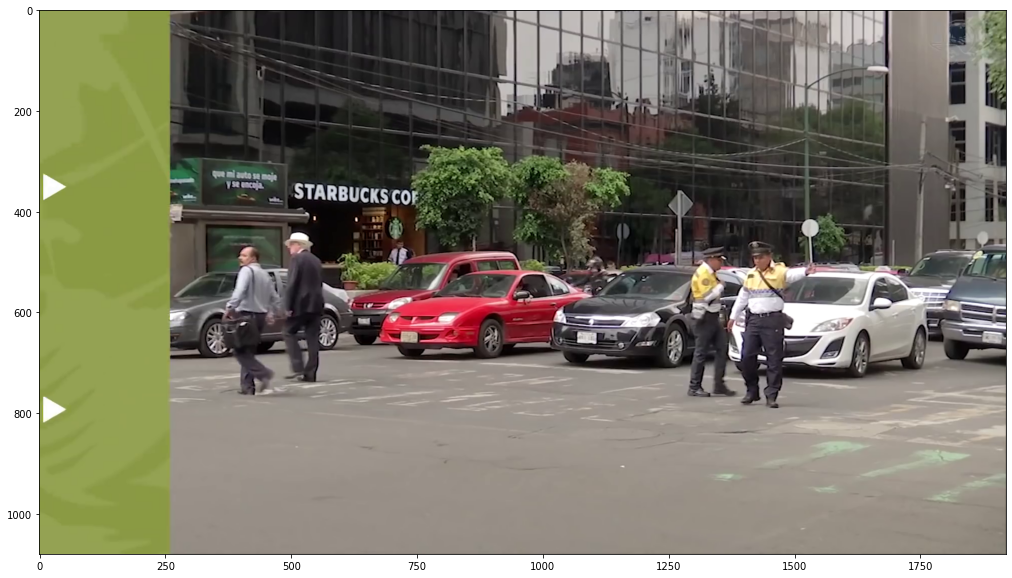

In [72]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(frame)